In [51]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes

        self.lr = learning_rate

        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        self.activation = lambda x: sp.expit(x)
        self.inverse_activation = lambda x: sp.logit(x)

        pass

    def train(self, inputs_list, targets_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation(final_inputs)

        outputs_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, outputs_errors)

        self.who += self.lr * np.dot(outputs_errors * final_outputs * (1 - final_outputs), hidden_outputs.T)
        self.wih += self.lr * np.dot(hidden_errors * hidden_outputs * (1 - hidden_outputs), inputs.T)

        pass

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation(final_inputs)

        return final_outputs

    def back_query(self, targets_list):
        final_outputs = np.array(targets_list, ndmin=2).T
        final_inputs = self.inverse_activation(final_outputs)

        hidden_outputs = np.dot(self.who.T, final_inputs)

        # scale them back to 0.01 to 0.99
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01

        hidden_inputs = self.inverse_activation(hidden_outputs)

        inputs = np.dot(self.wih.T, hidden_inputs)

        # scale them back to 0.01 to 0.99
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01

        return inputs

In [53]:
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.1

n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [54]:
with open('../data/mnist/mnist_train.csv', 'r') as train_f:
    train_data = [line.rstrip() for line in train_f]

with open('../data/mnist/mnist_test.csv') as test_f:
    test_data = [line.rstrip() for line in test_f]

In [55]:
def test_run():
    scorecard = []

    for record in test_data:
        all_values = record.split(',')
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        outputs = n.query(inputs)
        correct_label = int(all_values[0])
        label = np.argmax(outputs)

        if label == correct_label:
            scorecard.append(1)
        else:
            scorecard.append(0)

        pass

    scorecard_array = np.asarray(scorecard)
    print('performance:', scorecard_array.sum() / scorecard_array.size)

    pass

In [56]:
epochs = 6

for e in range(epochs):
    for record in train_data:
        all_values = record.split(',')
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = np.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass

    test_run()
    pass

performance: 0.9567
performance: 0.9683
performance: 0.9705
performance: 0.9728
performance: 0.9729
performance: 0.9725


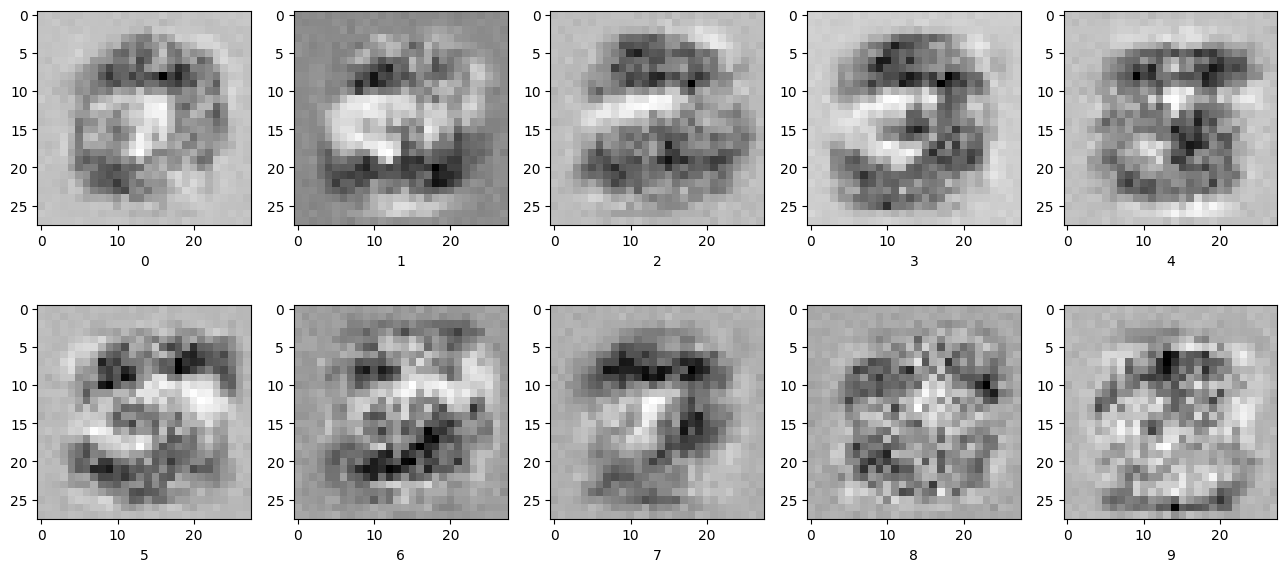

In [103]:
# back_query (how the neural network sees)
labels = 10

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 7))
arr = axes.flatten()

for i in range(len(arr)):
    targets = np.zeros(output_nodes) + 0.01
    targets[i] = 0.99
    image_data = n.back_query(targets)
    arr[i].imshow(image_data.reshape(28, -1), cmap='Greys', interpolation='None')
    arr[i].set_xlabel(i)
plt.show()